# TP6 - Procesamiento de Lenguaje Natural

Imports

In [9]:
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import itertools
import random
import math
import operator
import re
import nltk
import string
import xml.etree.ElementTree as et
from random import shuffle
from heapq import nsmallest
from nltk.corpus import wordnet
from lxml import etree
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
from nltk.corpus import stopwords, wordnet
from gensim import corpora, models, similarities, matutils
wnl = WordNetLemmatizer()
sns.plt = plt
# nltk.download()

## 1 - Asociacion de palabras
**1.1 Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario ( < doc_no > : < text > ).**

Librerias necesarias: html5lib, lxml, bs4, re

In [10]:
ap_xml_data = open('data/ap.txt').read()
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.TreebankWordTokenizer()

def word_normalize(txt):
    return txt.translate(None, string.punctuation).lower() #.replace("'", "")

def xml2df(xml_data):
    root = et.XML(xml_data, parser=etree.XMLParser(recover=True)) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            if subchild.tag=="DOCNO":
                record[subchild.tag] = subchild.text
            elif subchild.tag=="TEXT":
                record[subchild.tag] = beautify(word_normalize(subchild.text))
        all_records.append(record)
    df = pd.DataFrame(all_records)
    df.set_index('DOCNO', inplace=True)
    return df

def split(text):
    sentences = sent_detector.tokenize(text)
    tokens = [tokenizer.tokenize(sent) for sent in sentences]
    return tokens

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def pos_tag(tokens):
    pos_tokens = [nltk.pos_tag(token) for token in tokens]
    pos_tokens = [[(word, wnl.lemmatize(word,get_wordnet_pos(pos_tag)), [pos_tag]) 
                  for (word,pos_tag) in filter(lambda (w,t): get_wordnet_pos(t) != None,pos)] 
                  for pos in pos_tokens]
    return pos_tokens

def beautify(txt):
    tokens = split(txt)
    lemma_pos_token = pos_tag(tokens)
    return [w2.encode('utf-8') for sublist in lemma_pos_token for (w1,w2,t) in sublist]

In [512]:
ap_df = xml2df(ap_xml_data)

In [513]:
print "AP cargado."
print "Resumen de los primeros 10 documentos:"
print ap_df.iloc[0:10]

AP cargado.
Resumen de los primeros 10 documentos:
                                                              TEXT
DOCNO                                                             
 AP881218-0003   [student, private, baptist, school, allegedly,...
 AP880224-0195   [bechtel, group, inc, offer, sell, oil, israel...
 AP881017-0144   [gunman, take, woman, hostage, be, foil, attem...
 AP881017-0219   [today, be, saturday, day, be, day, leave, yea...
 AP900117-0022   [cupid, have, new, message, lover, valentine, ...
 AP880405-0167   [reagan, administration, be, weigh, invoke, la...
 AP880825-0239   [more, skin, protected, specie, alligator, be,...
 AP880325-0232   [be, organize, union, boost, single, candidate...
 AP880908-0056   [here, be, summary, development, forest, brush...
 AP881105-0097   [jeanpierre, stirbois, man, extremeright, nati...


**1.2 Calcular el tamano del vocabulario.**

In [514]:
freq_vocab = dict()
for index, row in ap_df.iterrows():
    for word in row[0]:
        freq_vocab[word] = freq_vocab.get(word, 0) + 1

In [515]:
print "El vocabulario tiene: " + str(len(freq_vocab)) + " palabras."

El vocabulario tiene: 31793 palabras.


**1.3 Para las 500 palabras con mas apariciones, calcular el par mas asociado segun la medida presentada.**

In [516]:
max_freq_vocab = dict(sorted(freq_vocab.iteritems(), key=operator.itemgetter(1), reverse=True)[:500])
print "Se obtuvieron las " + str(len(max_freq_vocab)) + " palabras con mas apariciones."

Se obtuvieron las 500 palabras con mas apariciones.


Usamos PMI:

Sean X,Y palabras, N la cantidad de palabras de todos los textos, W la ventana de co-ocurrencia:

f(X)=occurs(X). f(X,Y)=occurs(Y despues de X, a distancia <= W)/(W-1).

P(X)=f(X)/N. P(X,Y)=f(X,Y)/N.

I(X,Y)=log2(P(X,Y) / (P(X) x P(Y)))=log2( ( f(X,Y) x N ) / ( f(X) x f(Y) ))

In [517]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
def score_associated_pairs(txts, relevant_words, W):
    finder = BigramCollocationFinder.from_words(
        BigramCollocationFinder._build_new_documents(txts, BigramCollocationFinder.default_ws, pad_right=True),
        window_size=W)
    finder.apply_word_filter(lambda w: w not in relevant_words or w in stopwords.words('english'))
    finder.apply_ngram_filter(lambda w1, w2: w1==w2)
    return finder.score_ngrams(bigram_measures.pmi)
scores = score_associated_pairs(ap_df.iloc[:,0], max_freq_vocab.keys(), 5)

10 pares mas asociados

In [527]:
print pd.DataFrame([(w1,w2,r) for ((w1,w2),r) in scores[:10]], columns=["Word1","Word2","Rating"])

      Word1       Word2    Rating
0     prime    minister  7.808954
1   eastern      europe  7.373304
2     speak   condition  7.162189
3   michael     dukakis  6.904538
4  exchange       index  6.895922
5     human       right  6.885043
6      west      german  6.857743
7     value       index  6.829709
8      news  conference  6.802911
9     radio     station  6.719174


## 2 -  Informacion Lexica
Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.

**2.1 Procesar el texto, tokenizando eliminando signos de puntuacion.**

In [356]:
origin_txt = open('data/origin.txt').read()
origin_txt = beautify(word_normalize(origin_txt))

In [359]:
print origin_txt[0:50]

['origin', 'specie', 'introduction', 'board', 'hm', 'beagle', 'naturalist', 'i', 'be', 'much', 'struck', 'certain', 'fact', 'distribution', 'organic', 'being', 'inhabit', 'south', 'america', 'geological', 'relation', 'present', 'past', 'inhabitant', 'continent', 'fact', 'be', 'see', 'latter', 'chapter', 'volume', 'seem', 'throw', 'light', 'origin', 'speciesthat', 'mystery', 'mystery', 'have', 'be', 'call', 'great', 'philosopher', 'return', 'home', 'occur', 'something', 'perhaps', 'be', 'make']


**2.2 Siguiendo el artıculo de la seccion, calcular la autocorrelacion para estimar la distribucion de la palabra a lo largo del texto.**

In [318]:
def gaussian_kernel(t,sigma):
    return scipy.stats.norm.pdf(t, 0.0, sigma) #(np.e**(-t*t/(2*sigma*sigma)))/(math.sqrt(2*pi)*sigma)

def rate_of_occurence(points_of_interest, word_positions):
    return [sum([gaussian_kernel(t-x,50.0) for x in nsmallest(100, word_positions, key=lambda x: abs(x-t))[::2]]) for t in points_of_interest]

Vamos a testear las funciones para la palabra "instinct", la cual es usa en el paper:

In [380]:
def calculate_word_occurs(txt):
    occurs = dict()
    for i in range(len(txt)):
        word = txt[i]
        if (word in example_words):
            occurs[word] = occurs.get(word,[]) + [i]
    return occurs

example_words = ["instinct"]
example_word_occurs = calculate_word_occurs(origin_txt)
N = len(origin_txt)

In [369]:
POINT_STEP = 150
points_of_interest = range(0,N,POINT_STEP)
example_word_rates = dict()
for word in example_words:
    example_word_rates[word] = rate_of_occurence(points_of_interest, example_word_occurs[word]) #[rate_of_occurence(i,example_word_occurs[word]) for i in points_of_interest]

In [364]:
rate_df = pd.DataFrame(example_word_rates["instinct"], columns=['Rate'], index=points_of_interest)

Graficamos el 'rate of occurence' de la palabra 'instinct':

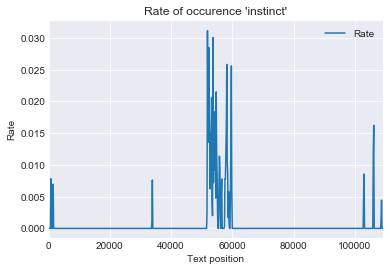

In [365]:
ax = rate_df.plot()
ax.set_title("Rate of occurence 'instinct'")
ax.set_xlabel("Text position")
ax.set_ylabel("Rate")
plt.show()

In [337]:
def autocorrelation(points,word_positions,rates):
    n = len(points)
    sum_rate = sum(rates)
    sum_sq_rate = sum([r*r for r in rates])
    denom = (sum_sq_rate / n) - (sum_rate / n) * (sum_rate / n)
    rates_off = rate_of_occurence(range(N,N+10000,POINT_STEP), word_positions)
    rates_tau = rates
    autocorr = []
    sum_rates = sum(rates)
    sum_rates_tau = sum_rates
    for rate in rates_off:
        sum_comp_rates = sum([rates[i] * rates_tau[i] for i in range(len(rates))])
        autocorr.append((sum_comp_rates / n - (sum_rates / n) * (sum_rates_tau / n)) / denom)
        sum_rates_tau = sum_rates_tau - rates_tau[0] + rate
        rates_tau = rates_tau[1:]
        rates_tau.append(rate)
    return autocorr

Se calcula la autocorrelacion de 'instinct' en el texto:

In [350]:
autocorr = autocorrelation(points_of_interest, example_word_occurs["instinct"], example_word_rates["instinct"])

Se hace un random shuffle del texto y se vuelve a calcular la autocorrelacion de 'instinct':

In [366]:
random_txt = origin_txt[:]
random.shuffle(random_txt)

In [381]:
random_word_occurs = calculate_word_occurs(random_txt)
random_word_rates = dict()
for word in example_words:
    random_word_rates[word] = rate_of_occurence(points_of_interest, random_word_occurs[word])

In [387]:
random_autocorr = autocorrelation(points_of_interest, random_word_occurs["instinct"], random_word_rates["instinct"])

Se grafica la autocorrelacion de 'instinct' comparandolo con el caso en que el texto se randomiza:

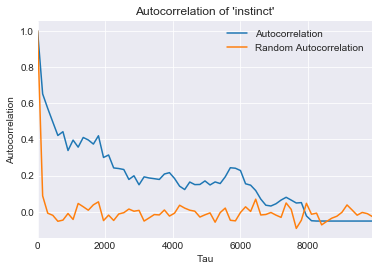

In [388]:
autocorr_df = pd.DataFrame(zip(autocorr,random_autocorr), columns=['Autocorrelation','Random Autocorrelation'], index=range(0,10000,POINT_STEP))
ax = autocorr_df.plot()
ax.set_title("Autocorrelation of 'instinct'")
ax.set_xlabel("Tau")
ax.set_ylabel("Autocorrelation")
plt.show()

**2.3 Calcular la entropia de una seleccion de 100 palabras que abarquen el rango de frecuencia de aparicion en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia.**

In [476]:
N = len(origin_txt)
P = 64
n = int(math.ceil(float(N)/P))
print "Se divide el texto de " + str(N) + " palabras en " + str(P) + " partes de (excepto la ultima) " + str(n) + " palabras."

def calculate_freqs_by_parts(txt):
    origin_freq_vocab = dict()
    origin_freq_vocab_by_part = dict()
    for i in range(len(txt)):
        word = txt[i]
        part = i / n
        origin_freq_vocab[word] = origin_freq_vocab.get(word, 0) + 1
        origin_freq_vocab_by_part[word] = origin_freq_vocab_by_part.get(word, dict())
        origin_freq_vocab_by_part[word][part] = origin_freq_vocab_by_part[word].get(part, 0) + 1
    return origin_freq_vocab, origin_freq_vocab_by_part

origin_freq_vocab, origin_freq_vocab_by_part = calculate_freqs_by_parts(origin_txt)

Se divide el texto de 109406 palabras en 64 partes de (excepto la ultima) 1710 palabras.


In [506]:
origin_sorted_freqs = sorted(origin_freq_vocab.iteritems(), key=operator.itemgetter(1), reverse=True)
origin_max_freq_vocab = [k for k,freq in origin_sorted_freqs]
origin_max_freq_vocab = origin_max_freq_vocab[5:35]+origin_max_freq_vocab[100:4000:65]+origin_max_freq_vocab[-10:]
print "Se toman " + str(len(origin_max_freq_vocab)) + " palabras que abarcan el rango de frecuencias."

Se toman 100 palabras que abarcan el rango de frecuencias.


Se calcula su entropia

In [512]:
def calculate_entropies(words, freqs, freqs_by_part):
    entropies = []
    for word in words:
        freq = freqs[word]
        entropy = -sum([(0 if freqs_by_part[word].get(part,0)<=0 else math.log(freqs_by_part[word].get(part,0)/float(n),2)*freqs_by_part[word].get(part,0)/float(n)) for part in range(P)])
        entropies.append((freq,entropy))
    return entropies

entropies = calculate_entropies(origin_max_freq_vocab, origin_freq_vocab, origin_freq_vocab_by_part)
entropies.sort()

In [513]:
entropies_df = pd.DataFrame(entropies, columns=["Frecuency","Entropy"])#[e for f,e in entropies], columns=["Entropy"], index=[f for f,e in entropies])

Se grafica la entropia

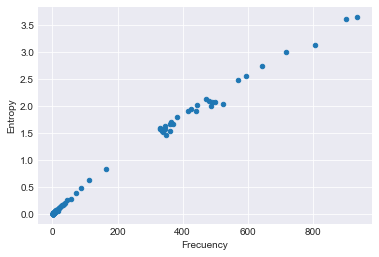

In [514]:
entropies_df.plot.scatter(x="Frecuency",y="Entropy")
plt.show()

**2.4 Calcular la entropia de las palabras seleccionadas anteriormente, randomizando su posicion en el texto. Comparar con los resultados del punto anterior.**

In [523]:
random_freq_vocab, random_freq_vocab_by_part = calculate_freqs_by_parts(random_txt)
random_entropies = calculate_entropies(origin_max_freq_vocab, random_freq_vocab, random_freq_vocab_by_part)
random_entropies.sort()

In [524]:
random_entropies_df = pd.DataFrame(random_entropies, columns=["Frecuency","Entropy"])

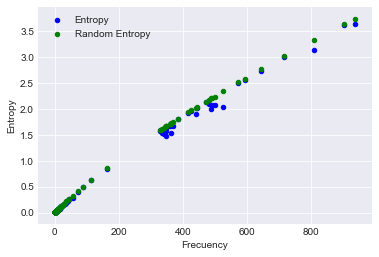

In [525]:
ax = entropies_df.plot.scatter(x="Frecuency", y="Entropy", color='Blue', label='Entropy')
ax = random_entropies_df.plot.scatter(x="Frecuency", y="Entropy", color='Green', label='Random Entropy', ax=ax)
plt.show()

## 3 - Word embeddings, distancia semantica y Word-Net
**3.1 Utilizando el test WordSim3531, comparar el rendimiento entre LSA[3] y Word2Vec2 [4].**

Carga de datos corpus

In [5]:
tasa_data = open('data/tasa.txt').read().split('[DOC]')[1:]

Tokenizar datos corpus tomando uno de cada 8

In [8]:
tasa_data = [beautify(word_normalize(doc)) for doc in tasa_data[::8]]

In [293]:
print "Se tiene un corpus de " + str(len(tasa_data)) + " documentos tokenizados."

Se tiene un corpus de 4707 documentos tokenizados.


Eliminamos las palabras que solo aparecen una vez

In [19]:
tasa_freqs = dict()
for doc in tasa_data:
    for word in doc:
        tasa_freqs[word] = tasa_freqs.get(word, 0) + 1
tasa_data = [[word for word in text if tasa_freqs[word] != 1] for text in tasa_data]

Pasamos el corpus a Gensim

In [295]:
dictionary = corpora.Dictionary(tasa_data)
corpus = [dictionary.doc2bow(doc) for doc in tasa_data]

Grabamos y traemos el diccionario y el corpus

In [296]:
# corpora.MmCorpus.serialize('data/tasa.mm', corpus)
# dictionary.save('data/tasa.dict')

In [14]:
corpus = corpora.MmCorpus('data/tasa.mm')
dictionary = corpora.Dictionary.load('data/tasa.dict')

Entrenamos LSA y Word2Vec

In [15]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=300)

In [16]:
wordsim = open('data/wordsim_similarity_goldstandard.txt').read()
word2vec = models.Word2Vec(tasa_data, size=100, window=10, min_count=5, workers=4)

Comparamos rendimiento de los algoritmos segun WordSim3531

In [35]:
def lsa_similarity(w1, w2):
    return (matutils.cossim(lsi[dictionary.doc2bow([w1])], lsi[dictionary.doc2bow([w2])])+1) / 2 * 10

def word2vec_similarity(w1, w2):
    return word2vec.wv.similarity(w1, w2) * 10

def error_histogram(result, title):
    lsa_rating_error = [ abs(lv-v) for v,lv,wv in result]
    w2v_rating_error = [ abs(wv-v) for v,lv,wv in result]

    plt.hist(lsa_rating_error, label="LSI", alpha=0.7, color='red')
    plt.hist(w2v_rating_error, label="Word2Vec", alpha=0.7)
    plt.title('Histograma de errores respecto a '+  title)
    plt.legend()
    plt.show()

In [20]:
results = [sentence.split(" ") for sentence in wordsim.splitlines()]
results = [[w1,w2,float(v),float('%.2f'%(lsa_similarity(w1,w2))),float('%.2f'%(word2vec_similarity(w1,w2)))] for w1,w2,v in results if (tasa_freqs.get(w1,0) > 1 and tasa_freqs.get(w2,0) > 1 and w1 in word2vec.wv.vocab and w2 in word2vec.wv.vocab)]

Tabla ratings comparado a WordSim3531 para cada par de palabras

In [363]:
results_df = pd.DataFrame(results, columns=["Word1","Word2","WordSim3531 Rating","LSA Rating","Word2Vec Rating"])
results_df[:10]

,Word1,Word2,WordSim3531 Rating,LSA Rating,Word2Vec Rating
0,tiger,cat,7.35,5.71,8.50
1,tiger,tiger,10.00,10.00,10.00
2,plane,car,5.77,4.79,5.82
3,train,car,6.31,5.36,6.49
4,television,radio,6.77,7.86,9.05
5,bread,butter,6.19,6.19,9.39
6,doctor,nurse,7.00,6.31,8.49
7,professor,doctor,6.62,5.56,7.41
8,student,professor,6.81,5.37,7.09
9,smart,stupid,5.81,5.11,9.71


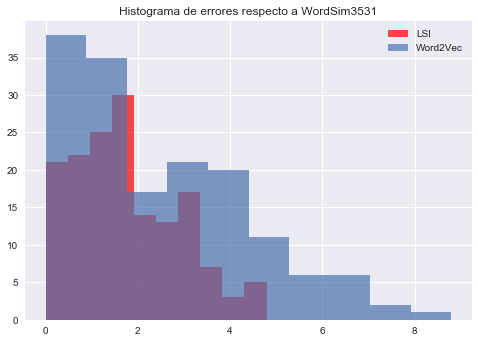

In [36]:
results_wordsim = [[v,lv,wv] for w1,w2,v,lv,wv in results]
error_histogram(results_wordsim, "WordSim3531")

Grafico de errores de rating para todas las palabras.
Observamos que LSI es superior a Word2Vec al compararlo con WordSim3531.
Hay que tener en cuenta que ambas fueron entrenadas con el mismo corpus.

Ahora, fijando la palabra 'tiger', hacemos el analisis de errores para cada palabra con respecto a esta

In [38]:
results_tiger = [[w1,w2,v,lsav,w2v] for w1,w2,v,lsav,w2v in results if w1=='tiger']
print pd.DataFrame(results_tiger, columns=["Word1","Word2","WordSim3531 Rating","LSA Rating","Word2Vec Rating"])

   Word1     Word2  WordSim3531 Rating  LSA Rating  Word2Vec Rating
0  tiger       cat                7.35        5.62             8.48
1  tiger     tiger               10.00       10.00            10.00
2  tiger    mammal                6.85        4.98             4.99
3  tiger    animal                7.00        5.16             2.96
4  tiger  organism                4.77        5.14             0.64


Y graficamos el histograma de errores con respecto a 'tiger'

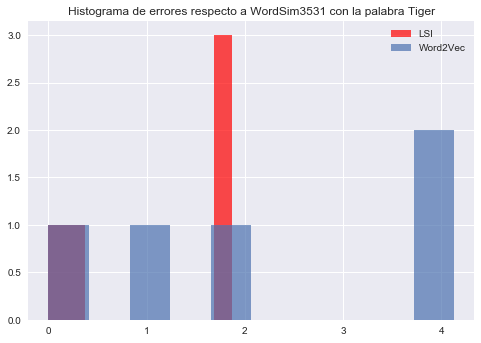

In [39]:
results_wordsim = [[v,lv,wv] for w1,w2,v,lv,wv in results_tiger]
error_histogram(results_wordsim, "WordSim3531 con la palabra Tiger")

**3.2 Comparar los distintos word embeddings con las medidas definidas en WordNet.**

Tomamos la medida de wup_similarity

In [44]:
# ic = nltk.corpus.wordnet_ic.ic('ic-brown.dat')
def wordnet_noun_wup_similarity(w1,w2):
    sim = 0.0
    for n1 in wordnet.synsets(w1, pos=wordnet.NOUN):
        for n2 in wordnet.synsets(w2, pos=wordnet.NOUN):
            if '\'%s.'%w1 in str(n1) and '\'%s.'%w2 in str(n2):
                sim = max(n1.wup_similarity(n2), sim)
    return sim * 10

In [45]:
results_wordnet = [[w1,w2,lsav,w2v,float('%.2f'%wordnet_noun_similarity(w1,w2))] for w1,w2,v,lsav,w2v in results]

Tabla de ratings con WordNet wup similarity, utilizando las palabras de WordSim3531

In [47]:
results_wordnet_df = pd.DataFrame(results_wordnet, columns=["Word1","Word2","LSA Rating","Word2Vec Rating","WordNet Rating"])
results_wordnet_df[:10]

,Word1,Word2,LSA Rating,Word2Vec Rating,WordNet Rating
0,tiger,cat,5.62,8.48,8.97
1,tiger,tiger,10.00,10.00,10.00
2,plane,car,4.73,5.91,6.32
3,train,car,5.37,5.55,7.37
4,television,radio,8.18,9.26,9.00
5,bread,butter,6.60,9.06,7.50
6,doctor,nurse,6.45,8.65,8.70
7,professor,doctor,5.52,7.46,5.45
8,student,professor,5.36,6.62,5.71
9,smart,stupid,5.37,9.58,1.33


Grafico de errores de rating para WordNet

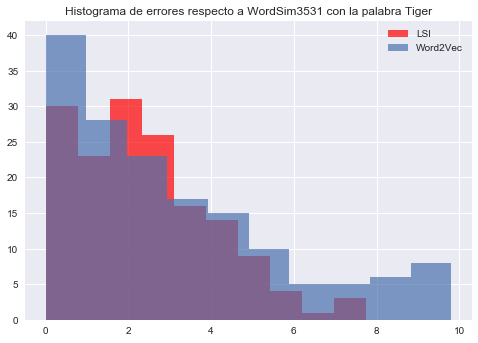

In [49]:
results_wordsim = [[v,lv,wv] for w1,w2,lv,wv,v in results_wordnet]
error_histogram(results_wordsim, "WordSim3531 con la palabra Tiger")

Ahora, fijando la palabra 'tiger', hacemos el analisis de errores para cada palabra con respecto a esta

In [52]:
results_tiger_wn = [[w1,w2,lv,wv,v] for w1,w2,lv,wv,v in results_wordnet if w1=='tiger']
pd.DataFrame(results_tiger_wn, columns=["Word1","Word2","LSA Rating","Word2Vec Rating","WordNet Rating"])

,Word1,Word2,LSA Rating,Word2Vec Rating,WordNet Rating
0,tiger,cat,5.62,8.48,8.97
1,tiger,tiger,10.00,10.00,10.00
2,tiger,mammal,4.98,4.99,8.00
3,tiger,animal,5.16,2.96,8.00
4,tiger,organism,5.14,0.64,8.57


Y graficamos los errores con respecto a 'tiger'

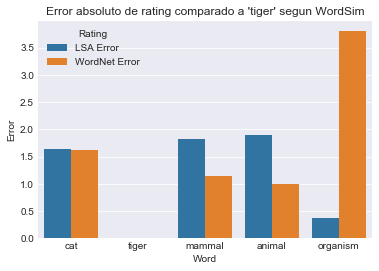

In [550]:
results_tiger_comp_wn = sum([[[w2,abs(lsav-v),"LSA Error"],[w2,abs(wnv-v),"WordNet Error"]] for w1,w2,v,lsav,w2v,wnv in results_wordnet if w1=='tiger'],[])
results_tiger_comp_wn_df = pd.DataFrame(results_tiger_comp_wn, columns=["Word","Error","Rating"])
ax = sns.barplot(x="Word", y="Error", hue="Rating", data=results_tiger_comp_wn_df)
ax.set_title("Error absoluto de rating comparado a 'tiger' segun WordSim")
plt.show()